In [1]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0  

## Introduction

**Auditing is a critical process that protects the financial interests of a certain company. Auditing firms examine various documents and books of accounts to avoid fraudulent behaviour and errors in general. Auditors confirm that companies are lawfully orchestrating their business transactions through a series of interviews and record checks. They produce and share their findings with the company and expect an action plan from the company moving forward. To analyze a company’s records, classification methods using R can predict if a company is likely fraudulent or not. The dataset used is a multivariate dataset with audit data from 777 firms during 2015 to 2016. This data can help answer the question: Is inherent risk a good predictor in predicting fraudulent behaviour of a company?**

## Preliminary exploratory data analysis

In [2]:
audit_risk <- read_csv("data/audit_risk.csv")
risk_dataset <- select(audit_risk, Score, Money_Value, Inherent_Risk, CONTROL_RISK, Detection_Risk, Audit_Risk, Risk)
risk_dataset <- tibble::rowid_to_column(risk_dataset, "ID")
risk_dataset

New names:
• `Score_B` -> `Score_B...7`
• `Score_B` -> `Score_B...11`
Rows: 776 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): LOCATION_ID
dbl (26): Sector_score, PARA_A, Score_A, Risk_A, PARA_B, Score_B...7, Risk_B...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ID,Score,Money_Value,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2.4,3.38,8.574,0.4,0.5,1.7148,1
2,2.0,0.94,2.554,0.4,0.5,0.5108,0
3,2.0,0.00,1.548,0.4,0.5,0.3096,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
774,2,0.00,1.456,0.4,0.5,0.2912,0
775,2,0.00,1.440,0.4,0.5,0.2880,0
776,2,0.32,1.464,0.4,0.5,0.2928,0


In [3]:
audit_risk_split <- initial_split(risk_dataset, prop = 0.75, strata = Risk)
audit_risk_train <- training(audit_risk_split)
audit_risk_test <- testing(audit_risk_split)

ID,Score,Money_Value,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,2,0.94,2.554,0.4,0.5,0.5108,0
3,2,0.00,1.548,0.4,0.5,0.3096,0
5,2,0.00,1.416,0.4,0.5,0.2832,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
718,2.6,0.90,2.930,1.2,0.5,1.7580,1
725,3.2,0.43,6.580,0.4,0.5,1.3160,1
746,3.2,16.09,12.118,0.4,0.5,2.4236,1


[1] 581

Risk,n,precentage
<dbl>,<int>,<dbl>
0,353,60.75731
1,228,39.24269


score_min,score_max
<dbl>,<dbl>
2,5.2


mean(Score)
<dbl>
2.710155


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



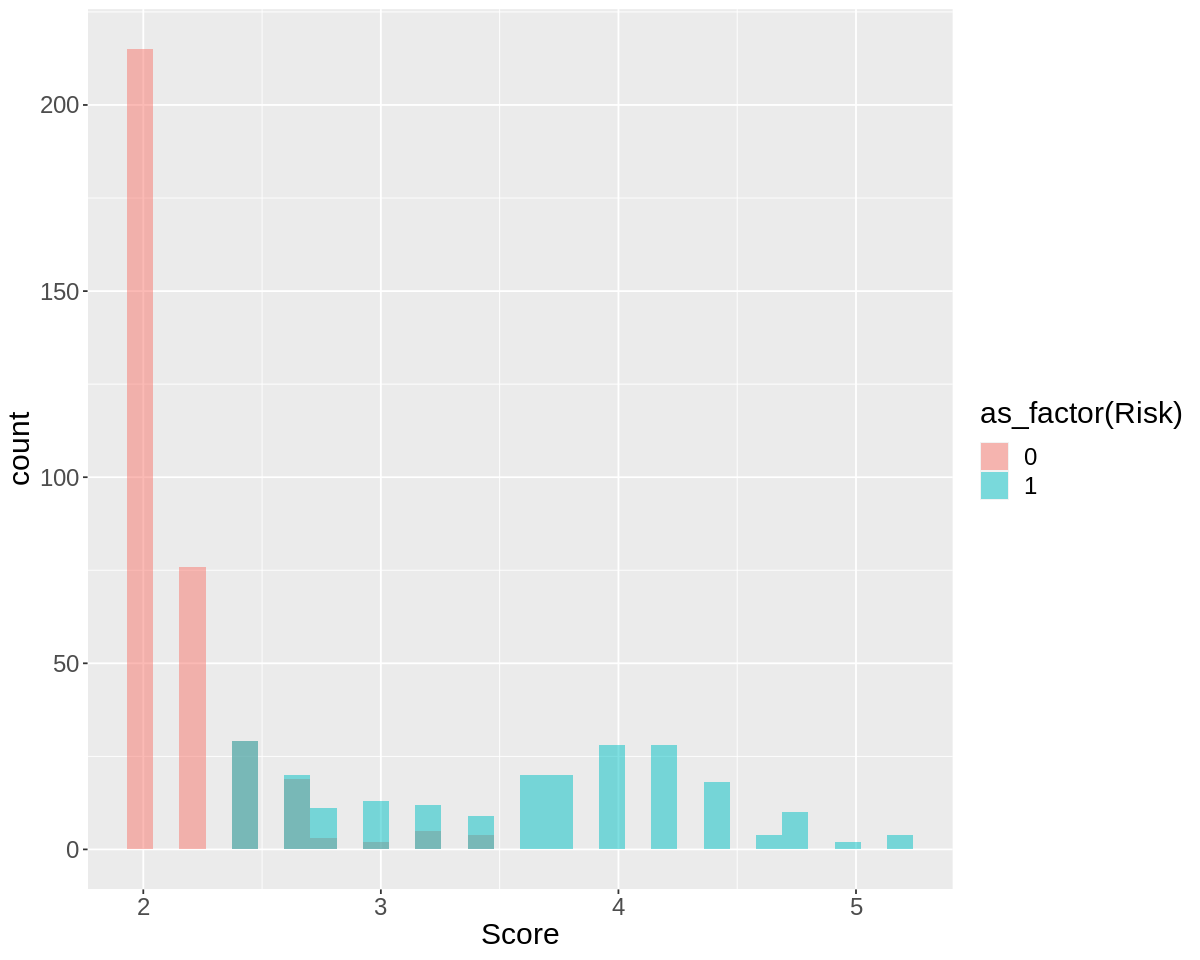

ID,Score,Money_Value,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
431,2.4,0.02,3.432,0.4,0.5,0.6864,0
305,2.0,0.04,1.586,0.4,0.5,0.3172,0
754,2.0,0.00,1.418,0.4,0.5,0.2836,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
590,2.0,0.02,1.404,0.4,0.5,0.2808,0
291,4.2,26.28,20.940,0.8,0.5,8.3760,1
728,2.0,0.42,1.670,0.4,0.5,0.3340,0


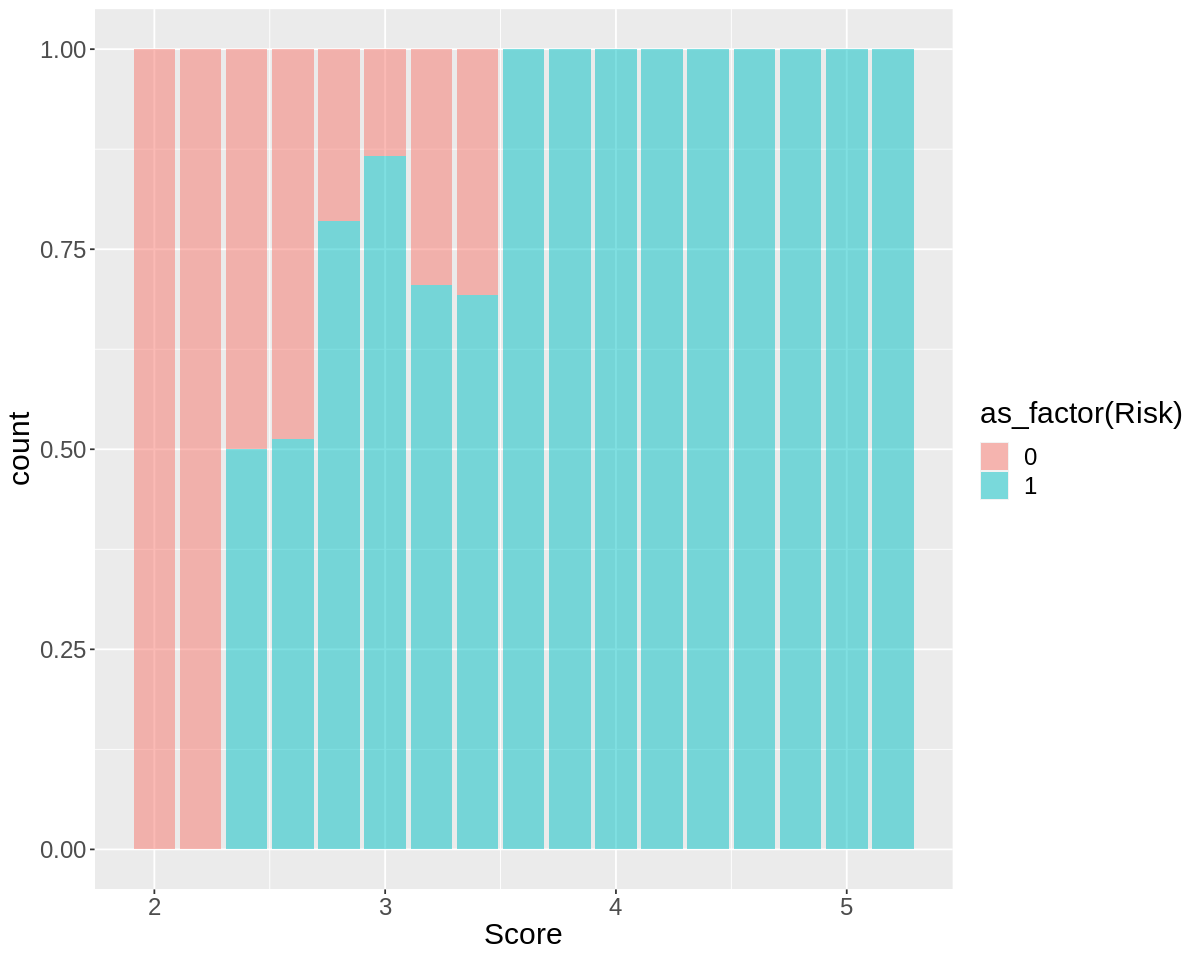

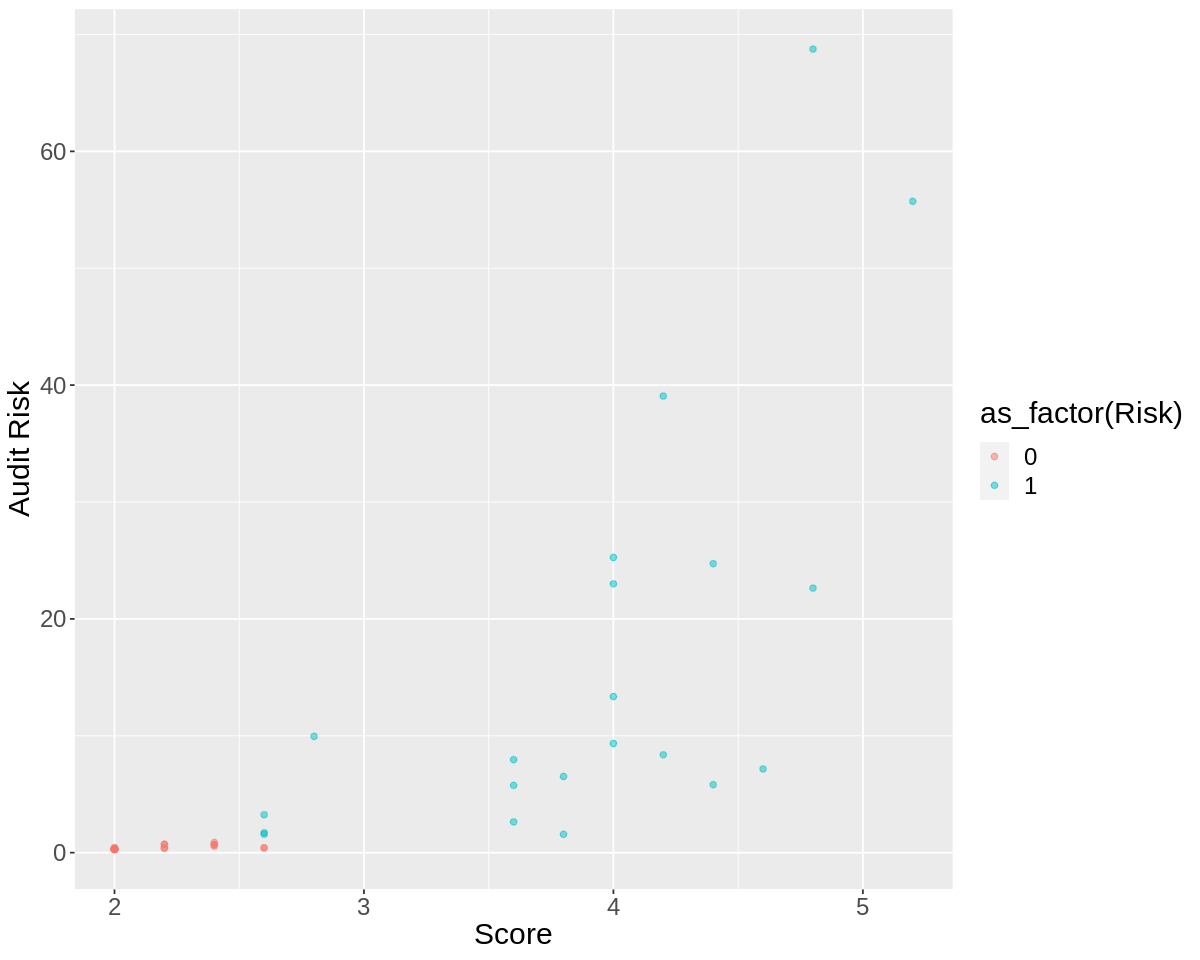

In [4]:
audit_risk_train
num_obs <- nrow(audit_risk_train)
num_obs

risk_sum <- audit_risk_train |>
group_by(Risk)|>
summarize(n = n(), precentage= n() / num_obs * 100) |>
arrange(desc(n))
risk_sum


Audit_Risk_score <- summarize(audit_risk_train, score_min = min(Score, na.rm = TRUE),
                 score_max = max(Score, na.rm = TRUE))
Audit_Risk_score

audit_risk_train |>
summarize(mean(Score))


options(repr.plot.width = 10, repr.plot.height = 8)
audit_risk_hist <- ggplot(audit_risk_train, aes(x = Score, fill = as_factor(Risk))) +
                          geom_histogram(alpha = 0.5, position = "identity") + theme(text = element_text(size = 18)) 
audit_risk_hist



audit_risk_barplot <- ggplot(audit_risk_train, aes(x = Score, fill = as_factor(Risk))) +
                          geom_bar(alpha = 0.5, position = "fill") + theme(text = element_text(size = 18)) 
audit_risk_barplot
data <- sample_n(audit_risk_train, 50)
data
audit_risk_point <- ggplot(data, aes(x = Score, y = Audit_Risk, color = as_factor(Risk))) +
                          geom_point(alpha = 0.5) + 
                          xlab("Score") +
                          ylab("Audit Risk") +
                          theme(text = element_text(size = 18)) 
audit_risk_point

## Methods

Risk is a assigned class to audit cases, which in the dataset, represents whether a company is fradulent using dummy/binary variable. (0 represents not fradulent; 1 represents fradulent). The goal of the project is to assist the auditors by developing a classification model to determine/predict whether a company is fraudulent or not based on the previous risk factors, which for this project, Score will be employed. 


## Expected outcomes and significance

**It is expected that as money value increases, the risk of fraudulence increases proportionally. This finding can impact bigger corporations, as the more money a company has, the more likely fraudulent behaviour has occurred within the company. This would prompt more audits to occur in these bigger companies to further investigate the likelihood of fraud. To combat the high risk of fraud, how can we monitor these corporations so that fraud is reduced as money value increases? What can governing bodies do to ensure discrepancies in accounts do not go unnoticed?**
